In [ ]:
# !pip install tensorflow_datasets

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [2]:
# load dataset from tfds and save to local directory (For analysis sake)
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete1H1XAR/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
class_names = info.features['label'].names

In [4]:
info.splits, info.supervised_keys

({Split('train'): <SplitInfo num_examples=23262, num_shards=8>},
 ('image', 'label'))

In [5]:
# save the dataset to your local directory
# iterate over the train set
for i, example in enumerate(dataset['train']):
  image, label = example
  save_dir = 'cats_vs_dogs/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)
  filepath = save_dir + '/' + class_names[label] + str(i) + '.jpg'
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())

## Image Data Generator for Base Classifier

base classifier means no data augmentation is done on the images

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_generator = datagen.flow_from_directory('cats_vs_dogs', target_size=(228, 228), batch_size=32,
                                              class_mode='binary', subset='training')

validation_generator = datagen.flow_from_directory('cats_vs_dogs', target_size=(228, 228), batch_size=32, class_mode='binary', subset='validation')

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


## Data Visualization

In [7]:
def plot_images(tarin_generator):
  plt.figure(figsize=(18,6))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    batch = train_generator.next()
    image = batch[0].astype('uint8')
    plt.imshow(image[0])
  plt.show()


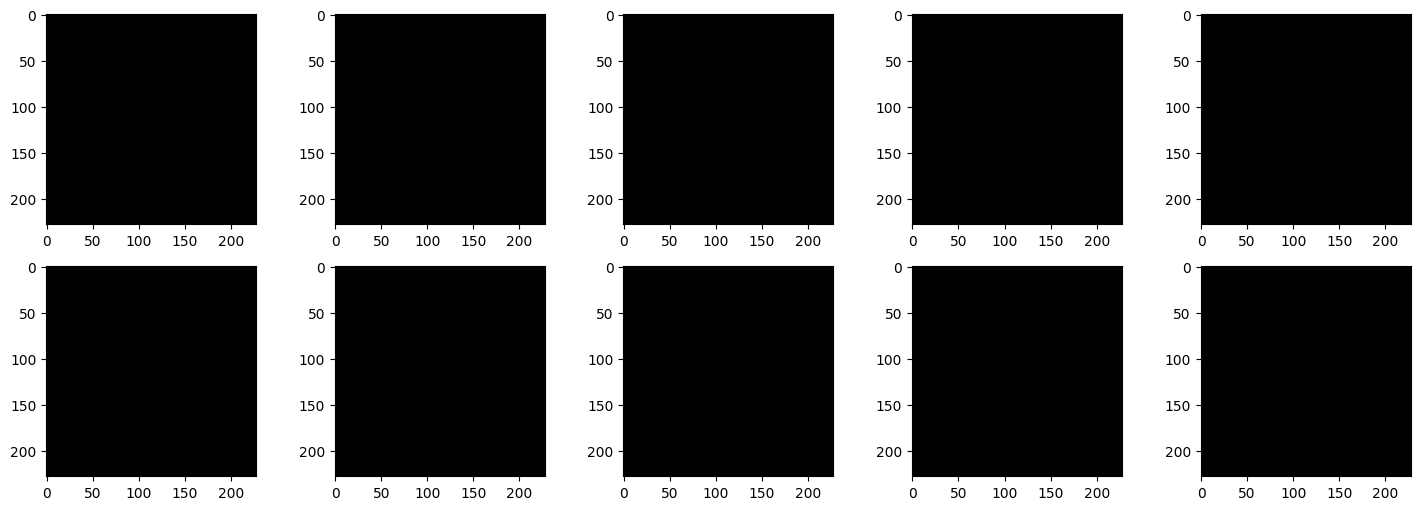

In [8]:
plot_images(train_generator)

In [9]:
# Because the images has been rescaled that's why it's hard to see, but if the rescale is removed, you'll be able to see

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

def get_base_model():
  model = Sequential()
  # 1st CNN layer
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(228, 228, 3)))
  model.add(MaxPooling2D(2,2))
  # 2nd CNN layer
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  # 3rd CNN layer
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  # flatten layer
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  return model


In [11]:
model = get_base_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [12]:
weights, biases = model.layers[0].get_weights()
len(biases)

32

## Model Training for Base CNN

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
582/582 [==============================] - 110s 166ms/step - loss: 0.6313 - accuracy: 0.6543 - val_loss: 0.5261 - val_accuracy: 0.7411
Epoch 2/5
582/582 [==============================] - 61s 105ms/step - loss: 0.4870 - accuracy: 0.7663 - val_loss: 0.4650 - val_accuracy: 0.7811
Epoch 3/5
582/582 [==============================] - 63s 108ms/step - loss: 0.3904 - accuracy: 0.8252 - val_loss: 0.4437 - val_accuracy: 0.7990
Epoch 4/5
582/582 [==============================] - 63s 108ms/step - loss: 0.2722 - accuracy: 0.8870 - val_loss: 0.5164 - val_accuracy: 0.7859
Epoch 5/5
582/582 [==============================] - 65s 111ms/step - loss: 0.1297 - accuracy: 0.9509 - val_loss: 0.6346 - val_accuracy: 0.7960


## Plot epochs history

In [14]:
def plot_train_hist(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Training accuracy vs Validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'])
plt.show()

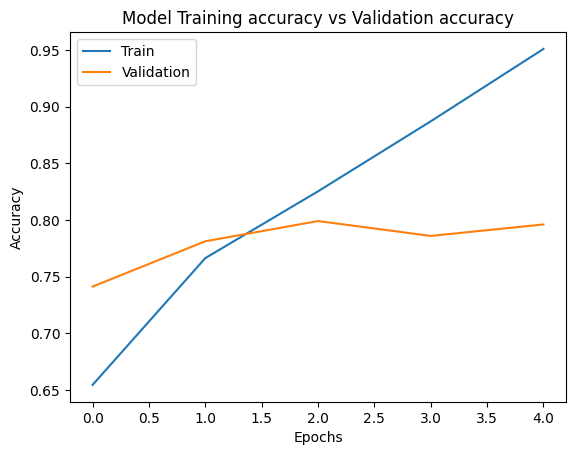

In [15]:
plot_train_hist(history)

## Image Data Generator for Regularized Classifier


In [16]:
datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True, validation_split=0.2, shear_range=0.1,
                             width_shift_range=0.1, rotation_range=0.1, zoom_range=0.1,
                             height_shift_range=0.1)

train_generator = datagen.flow_from_directory('cats_vs_dogs', target_size=(228,228), batch_size=32,
                                              class_mode='binary', subset='training')

validation_generator = datagen.flow_from_directory('cats_vs_dogs', target_size=(228,228), batch_size=32,
                                              class_mode='binary', subset='validation')

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


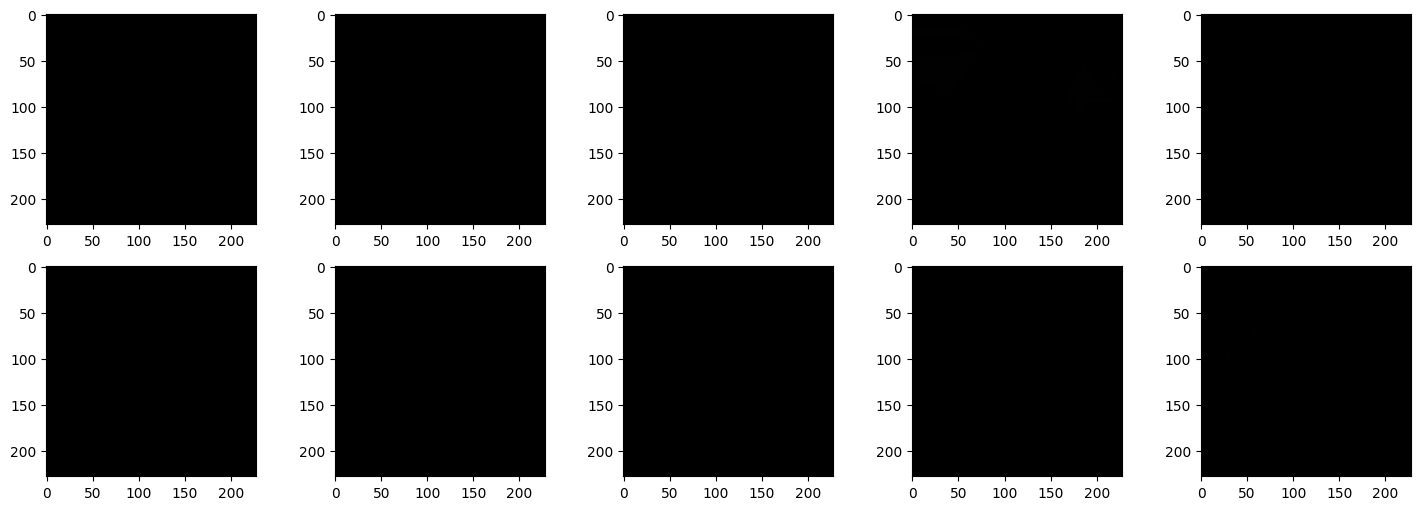

In [17]:
plot_images(train_generator)

In [18]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [19]:
def get_regularized_model():
  model = Sequential()
  # 1st CNN layer
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(228, 228, 3)))
  model.add(MaxPooling2D(2,2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  # 2nd CNN layer
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  # 3rd CNN layer
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  # flatten layer
  model.add(Flatten())
  model.add(Dropout(0.5))

  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [20]:
model = get_regularized_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 113, 113, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 113, 113, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 113, 113, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 55, 55, 64)       

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, epochs=4, validation_data=validation_generator)

Epoch 1/4
582/582 [==============================] - 378s 640ms/step - loss: 2.3272 - accuracy: 0.6388 - val_loss: 0.6392 - val_accuracy: 0.6736
Epoch 2/4
582/582 [==============================] - 340s 585ms/step - loss: 0.5665 - accuracy: 0.7124 - val_loss: 0.6268 - val_accuracy: 0.6652
Epoch 3/4
582/582 [==============================] - 330s 568ms/step - loss: 0.5287 - accuracy: 0.7381 - val_loss: 0.6354 - val_accuracy: 0.6743
Epoch 4/4
582/582 [==============================] - 328s 564ms/step - loss: 0.4967 - accuracy: 0.7569 - val_loss: 0.4625 - val_accuracy: 0.7850


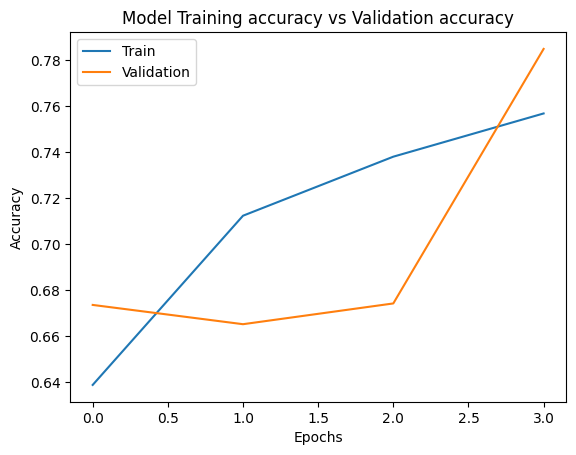

In [22]:
plot_train_hist(history)

## Save and Load Regularized Model

In [23]:
model.save('cats_vs_dogs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model_load = tf.keras.models.load_model('cats_vs_dogs.h5')

TypeError: ignored

In [29]:
img = tf.keras.preprocessing.image.load_img('/content/cats_vs_dogs/dog/dog10001.jpg')
img = img.resize((228, 228))
image_array = tf.keras.preprocessing.image.img_to_array(img)
images = np.expand_dims(image_array, axis = 0)
images = images/255
prediction = model.predict(images)

TH = 0.5

predicted_idx = int(prediction[0][0] > TH)

labels = {v:k for k,v in train_generator.class_indices.items()}
labels[predicted_idx]

1/1 [==============================] - 0s 21ms/step


'dog'

## CNN Model Visualization

In [26]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.3 MB/s eta 0:00:00


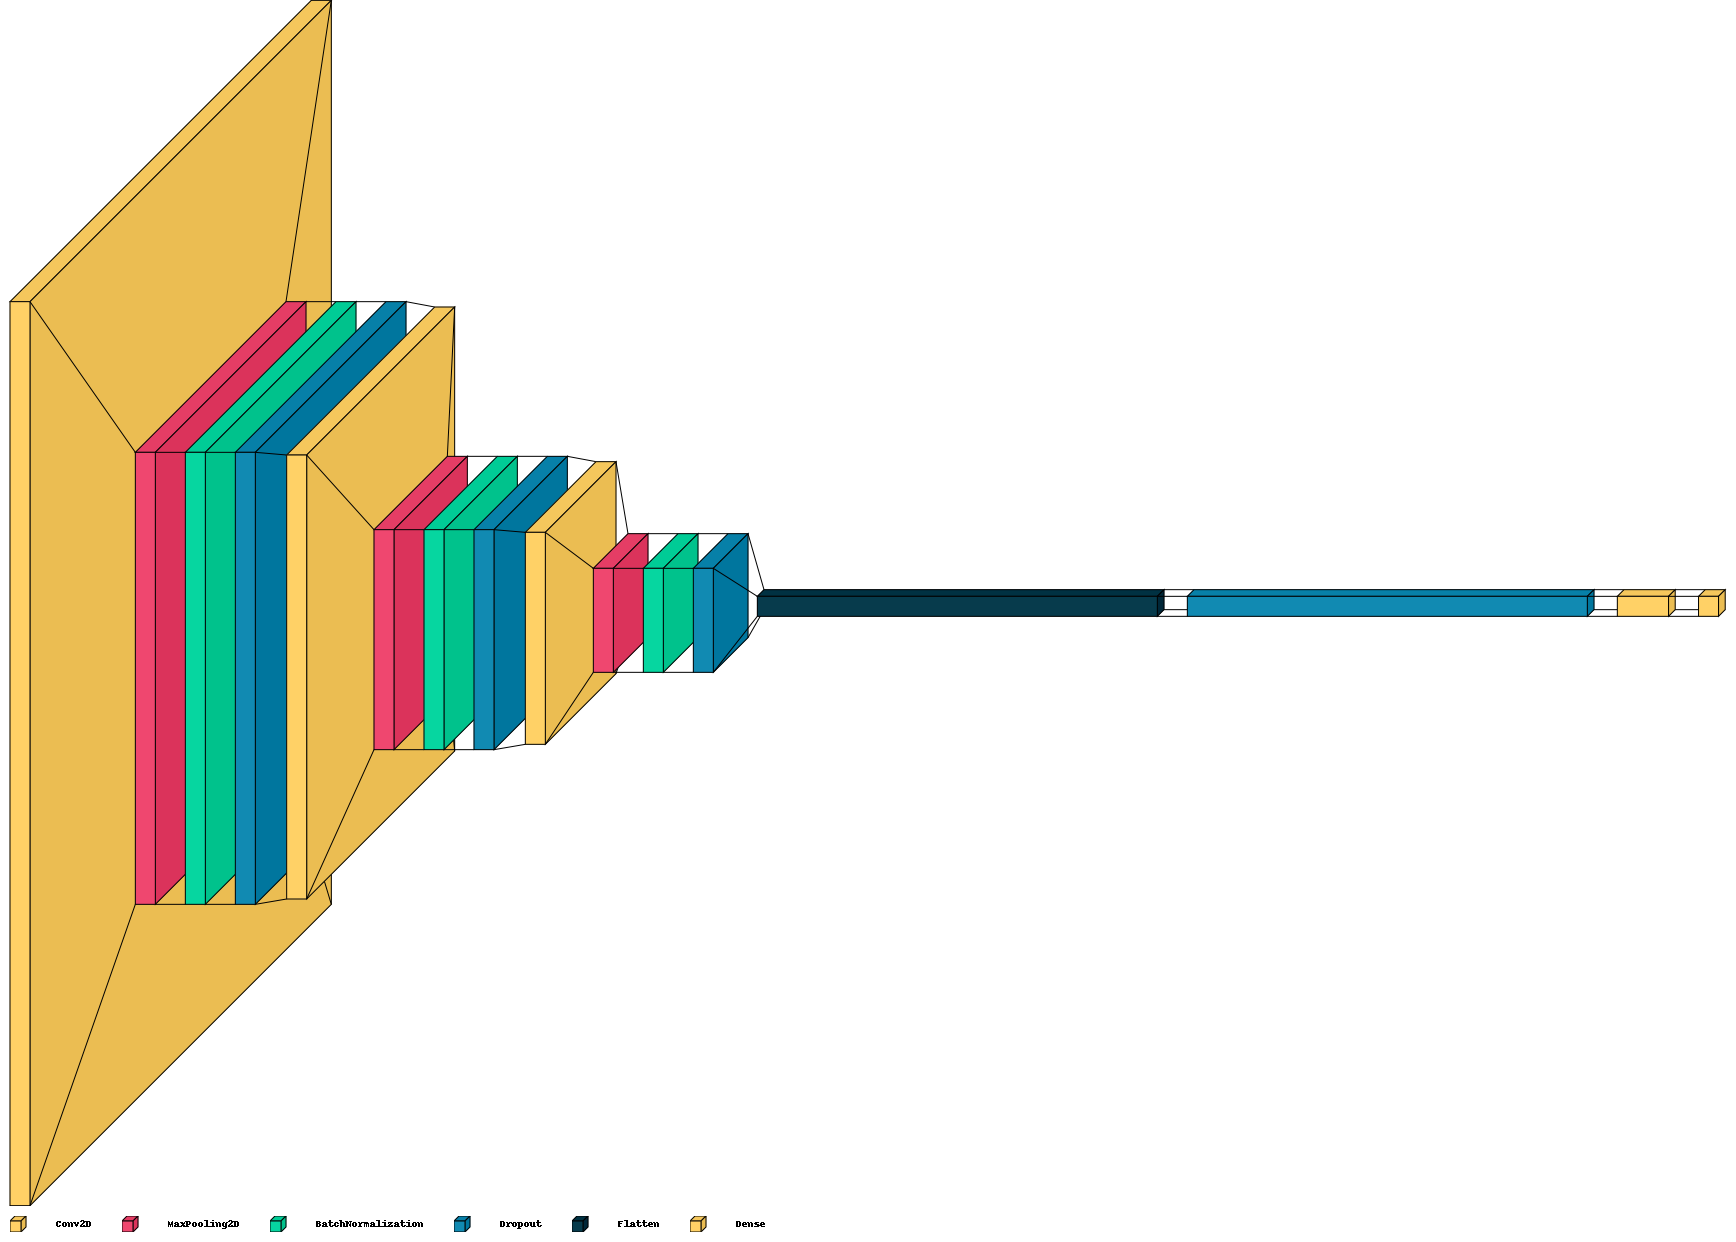

In [35]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend= True, spacing= 30, draw_funnel=True)
